#### Explainability of BERT using SHAP

In [ ]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'feature/bert-shap-2'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy shap
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive

    drive.mount('/content/drive')

In [1]:
import os
import torch

import pandas as pd
from utils.constants import DATA_PATH, MODEL_SAVE_PATH

DATA_PATH

'/home/michael/PycharmProjects/spam-detection-data'

In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [3]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200
pretrained_embeddings = None

In [4]:
from models.bert import SpamBERT
from transformers import BertTokenizer

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = SpamBERT(dropout=0.2)

# Load the trained model weights
model_path = os.path.join(MODEL_SAVE_PATH, 'spam_bert_final.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

SpamBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [5]:
from models.bert import tokenize_texts

# Tokenize test data
X_test_input_ids, X_test_attention_mask = tokenize_texts(test_df['text'].tolist(), tokenizer)
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_input_ids = X_test_input_ids.to(device)
X_test_attention_mask = X_test_attention_mask.to(device)
y_test_tensor = y_test_tensor.to(device)

print(f"Test data prepared: {X_test_input_ids.shape[0]} samples")

Test data prepared: 606 samples


In [6]:
# Get model predictions using BERT tokenized inputs
with torch.no_grad():
    model_output = model(
        input_ids=X_test_input_ids,
        attention_mask=X_test_attention_mask
    )
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

print(f"Model predictions computed for {len(y_pred)} samples")
print(f"Predicted spam samples: {(y_pred == 1).sum().item()}")
print(f"Predicted ham samples: {(y_pred == 0).sum().item()}")

Model predictions computed for 606 samples
Predicted spam samples: 194
Predicted ham samples: 412


In [7]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


#### SHAP for BERT

In [8]:
from explainability.BertShapExplainer import BertShapExplainer
from explainability.BertShapMetrics import BertShapMetrics

# Initialize BERT SHAP explainer
print("Initializing BERT SHAP explainer...")
shap_explainer = BertShapExplainer(model, tokenizer, max_length=512, device=device)

# Use a subset of training data as background for SHAP
background_size = 100  # Reduce for faster computation
background_texts = train_df['text'].tolist()[:background_size]

print(f"Setting up SHAP explainer with {len(background_texts)} background samples...")
shap_explainer.setup_explainer(background_texts)

Initializing BERT SHAP explainer...
Setting up SHAP explainer with 100 background samples...
Setting up SHAP explainer with 100 background samples...
SHAP explainer setup complete


In [9]:
# Initialize metrics calculator
metrics_calculator = BertShapMetrics(shap_explainer, device=device)

explanation_times = []

# Select a few sample texts to analyze
sample_indices = samples
sample_texts = [test_df.iloc[idx]['text'] for idx in sample_indices]
sample_subjects = [test_df.iloc[idx]['subject'] for idx in sample_indices]
sample_labels = [test_df.iloc[idx]['label'] for idx in sample_indices]

print("Analyzing SHAP explanations for sample texts...")
shap_results = []

for i, (text, label, subject) in enumerate(zip(sample_texts, sample_labels, sample_subjects)):
    print(f"\n{'='*50}")
    print(f"Sample {i+1} (Index: {sample_indices[i]}, Label: {'Spam' if label == 1 else 'Ham'})")
    print(f"Subject: {subject}")
    print(f"{'='*50}")
    
    # Get SHAP explanation
    print("Computing SHAP values...")
    start_time = pd.Timestamp.now()
    tokens, shap_values = shap_explainer.explain_text_simple(text, nsamples=100)
    end_time = pd.Timestamp.now()
    explanation_times.append(end_time - start_time)
    print(f"Explanation time: {end_time - start_time}")
    
    # Get top features
    top_features = shap_explainer.get_top_features(tokens, shap_values, top_k=10)
    print(f"\nTop 10 SHAP features:")
    for j, (token, importance) in enumerate(top_features):
        print(f"  {j+1:2d}. '{token}': {importance:.4f}")
    
    # Store results
    shap_results.append({
        'index': sample_indices[i],
        'text': text,
        'subject': subject,
        'label': label,
        'tokens': tokens,
        'shap_values': shap_values,
        'top_features': top_features
    })

print(f"\nSHAP explanations computed for {len(shap_results)} samples")

Analyzing SHAP explanations for sample texts...

Sample 1 (Index: 150, Label: Ham)
Subject: Seeing is believing
Computing SHAP values...
Explaining text with 16 words using 100 samples...

Top 10 SHAP features:
   1. 'now': 0.0031
   2. 'believing': 0.0029
   3. 'what': 0.0027
   4. 'collections': 0.0026
   5. 'until': 0.0024
   6. 'grant': 0.0023
   7. 'paris': 0.0023
   8. 'make': 0.0022
   9. 'linda': 0.0020
  10. 'seeing': 0.0012

Sample 2 (Index: 357, Label: Ham)
Subject: Apple Store eNews : November 2002
Computing SHAP values...
Explaining text with 38 words using 100 samples...

Top 10 SHAP features:
   1. 'enjoy': 0.0021
   2. 'our': 0.0016
   3. 'where': 0.0016
   4. 'you': 0.0013
   5. 'we': 0.0013
   6. 'following': 0.0011
   7. 'because': 0.0010
   8. 'we': 0.0009
   9. 'want': 0.0009
  10. 'email': 0.0009

Sample 3 (Index: 402, Label: Ham)
Subject: RE: [ILUG] NVIDIA and Debian Woody
Computing SHAP values...
Explaining text with 498 words using 100 samples...

Top 10 SHAP f

In [ ]:
# create explanation time data frame
explanation_time_df = pd.DataFrame(explanation_times)
explanation_time_df.describe()

### Explanation Quality Metrics

We now compute four key explanation quality metrics for BERT SHAP explanations:

1. **AUC-Del (Area Under Deletion Curve)**: Measures how much the prediction changes when we progressively remove the most important features. Lower values are better.

2. **AUC-Ins (Area Under Insertion Curve)**: Measures how much the prediction improves when we progressively add the most important features. Higher values are better.

3. **Comprehensiveness**: Measures the prediction change when removing the top-k most important features. Higher values indicate the explanation captures important features.

4. **Jaccard Stability**: Measures how consistent the top-k important features are across perturbed versions of the input. Higher values indicate more stable explanations.

In [10]:
# Compute explanation quality metrics for each sample
import pandas as pd

metrics_results = []
metrics_time = []

for i, result in enumerate(shap_results):
    print(f"\n{'='*60}")
    print(f"Computing Explanation Quality Metrics for Sample {i+1}")
    print(f"Text: {result['subject']}")
    print(f"{'='*60}")
    
    # Compute all metrics
    start_time = pd.Timestamp.now()
    metrics = metrics_calculator.evaluate_explanation_quality(
        result['text'], 
        result['shap_values'], 
        verbose=True
    )
    end_time = pd.Timestamp.now()
    metrics_time.append(end_time - start_time)
    print(f"Metrics computation time: {end_time - start_time}")
    
    # Add sample information
    metrics['sample_index'] = result['index']
    metrics['label'] = result['label']
    metrics['text_length'] = len(result['text'].split())
    
    metrics_results.append(metrics)

# Create summary DataFrame
metrics_df = pd.DataFrame(metrics_results)
print(f"\n{'='*60}")
print("EXPLANATION QUALITY METRICS SUMMARY")
print(f"{'='*60}")
print(metrics_df[['sample_index', 'label', 'auc_deletion', 'auc_insertion', 
                  'comprehensiveness', 'jaccard_stability']].round(4))


Computing Explanation Quality Metrics for Sample 1
Text: Seeing is believing
Evaluating explanation quality for text: seeing believing url <URL> author linda grant neve...
AUC-Del: 0.1421 (lower is better)
AUC-Ins: 0.2969 (higher is better)
Comprehensiveness: 0.0026 (higher is better)
Explaining text with 15 words using 500 samples...
Explaining text with 15 words using 500 samples...
Explaining text with 15 words using 500 samples...
Explaining text with 16 words using 500 samples...
Explaining text with 15 words using 500 samples...
Explaining text with 16 words using 500 samples...
Explaining text with 15 words using 500 samples...
Explaining text with 13 words using 500 samples...
Explaining text with 15 words using 500 samples...
Explaining text with 14 words using 500 samples...
Jaccard Stability: 0.1972 (higher is better)

Computing Explanation Quality Metrics for Sample 2
Text: Apple Store eNews : November 2002
Evaluating explanation quality for text: apple store enews novembe

In [ ]:
# create explanation metrics time data frame
metrics_time_df = pd.DataFrame(metrics_time)
metrics_time_df.describe()

Generating deletion and insertion curve plots...

Plotting curves for: Seeing is believing


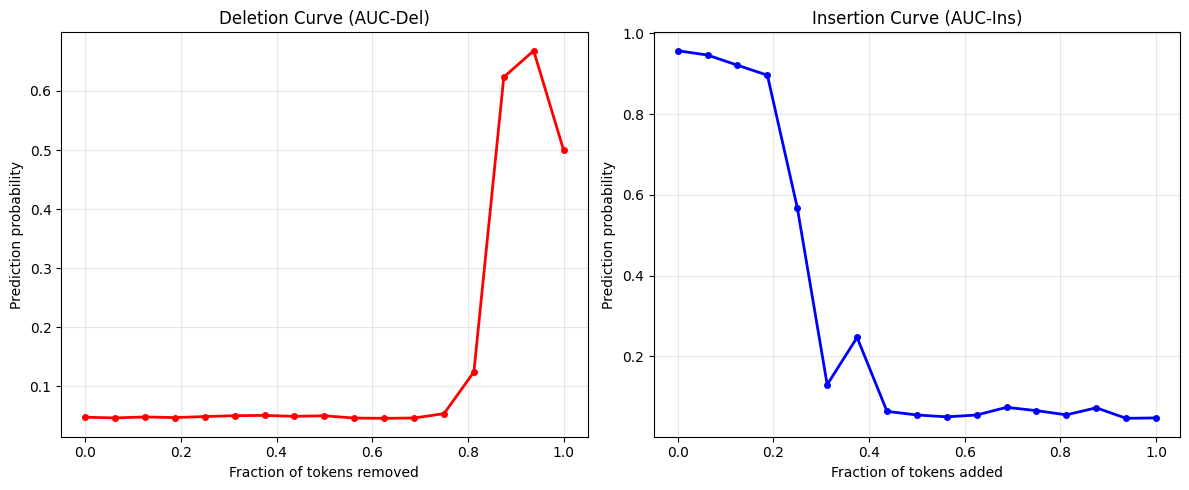

In [11]:
# Visualize deletion and insertion curves for the first sample
print("Generating deletion and insertion curve plots...")

# Plot for the first sample
if shap_results:
    sample_result = shap_results[0]
    print(f"\nPlotting curves for: {sample_result['subject']}")
    
    metrics_calculator.plot_deletion_insertion_curves(
        sample_result['text'], 
        sample_result['shap_values'],
        steps=15
    )

In [12]:
# Analyze metrics by label (spam vs ham)
print("\n" + "="*60)
print("METRICS ANALYSIS BY LABEL")
print("="*60)

spam_metrics = metrics_df[metrics_df['label'] == 1]
ham_metrics = metrics_df[metrics_df['label'] == 0]

print(f"\nSPAM samples ({len(spam_metrics)} samples):")
if len(spam_metrics) > 0:
    print(f"  AUC-Del (avg):        {spam_metrics['auc_deletion'].mean():.4f} ± {spam_metrics['auc_deletion'].std():.4f}")
    print(f"  AUC-Ins (avg):        {spam_metrics['auc_insertion'].mean():.4f} ± {spam_metrics['auc_insertion'].std():.4f}")
    print(f"  Comprehensiveness:    {spam_metrics['comprehensiveness'].mean():.4f} ± {spam_metrics['comprehensiveness'].std():.4f}")
    print(f"  Jaccard Stability:    {spam_metrics['jaccard_stability'].mean():.4f} ± {spam_metrics['jaccard_stability'].std():.4f}")

print(f"\nHAM samples ({len(ham_metrics)} samples):")
if len(ham_metrics) > 0:
    print(f"  AUC-Del (avg):        {ham_metrics['auc_deletion'].mean():.4f} ± {ham_metrics['auc_deletion'].std():.4f}")
    print(f"  AUC-Ins (avg):        {ham_metrics['auc_insertion'].mean():.4f} ± {ham_metrics['auc_insertion'].std():.4f}")
    print(f"  Comprehensiveness:    {ham_metrics['comprehensiveness'].mean():.4f} ± {ham_metrics['comprehensiveness'].std():.4f}")
    print(f"  Jaccard Stability:    {ham_metrics['jaccard_stability'].mean():.4f} ± {ham_metrics['jaccard_stability'].std():.4f}")

print(f"\nOVERALL metrics ({len(metrics_df)} samples):")
print(f"  AUC-Del (avg):        {metrics_df['auc_deletion'].mean():.4f} ± {metrics_df['auc_deletion'].std():.4f}")
print(f"  AUC-Ins (avg):        {metrics_df['auc_insertion'].mean():.4f} ± {metrics_df['auc_insertion'].std():.4f}")
print(f"  Comprehensiveness:    {metrics_df['comprehensiveness'].mean():.4f} ± {metrics_df['comprehensiveness'].std():.4f}")
print(f"  Jaccard Stability:    {metrics_df['jaccard_stability'].mean():.4f} ± {metrics_df['jaccard_stability'].std():.4f}")


METRICS ANALYSIS BY LABEL

SPAM samples (3 samples):
  AUC-Del (avg):        0.9473 ± 0.0067
  AUC-Ins (avg):        0.7511 ± 0.1763
  Comprehensiveness:    0.0022 ± 0.0036
  Jaccard Stability:    0.0767 ± 0.1142

HAM samples (3 samples):
  AUC-Del (avg):        0.0983 ± 0.0405
  AUC-Ins (avg):        0.3265 ± 0.2709
  Comprehensiveness:    0.0012 ± 0.0012
  Jaccard Stability:    0.1378 ± 0.1098

OVERALL metrics (6 samples):
  AUC-Del (avg):        0.5228 ± 0.4657
  AUC-Ins (avg):        0.5388 ± 0.3096
  Comprehensiveness:    0.0017 ± 0.0025
  Jaccard Stability:    0.1073 ± 0.1056


### Interpretation of Results

The explanation quality metrics provide insights into how well SHAP explanations capture the model's decision-making process:

**Metrics Interpretation:**
- **AUC-Del**: Lower values indicate that removing important features significantly impacts predictions (good explanations)
- **AUC-Ins**: Higher values indicate that adding important features progressively improves predictions (good explanations)  
- **Comprehensiveness**: Higher values show that top features have strong impact on predictions (good explanations)
- **Jaccard Stability**: Higher values indicate consistent feature importance across perturbations (stable explanations)

**Key Findings:**
1. The deletion curves show how prediction confidence decreases as we remove the most important SHAP features
2. The insertion curves demonstrate how prediction confidence builds up as we add important features
3. Comparing metrics between spam and ham samples reveals whether explanations are equally reliable for both classes
4. Stability metrics indicate how robust the explanations are to small input variations